In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

[*********************100%***********************]  1 of 1 completed


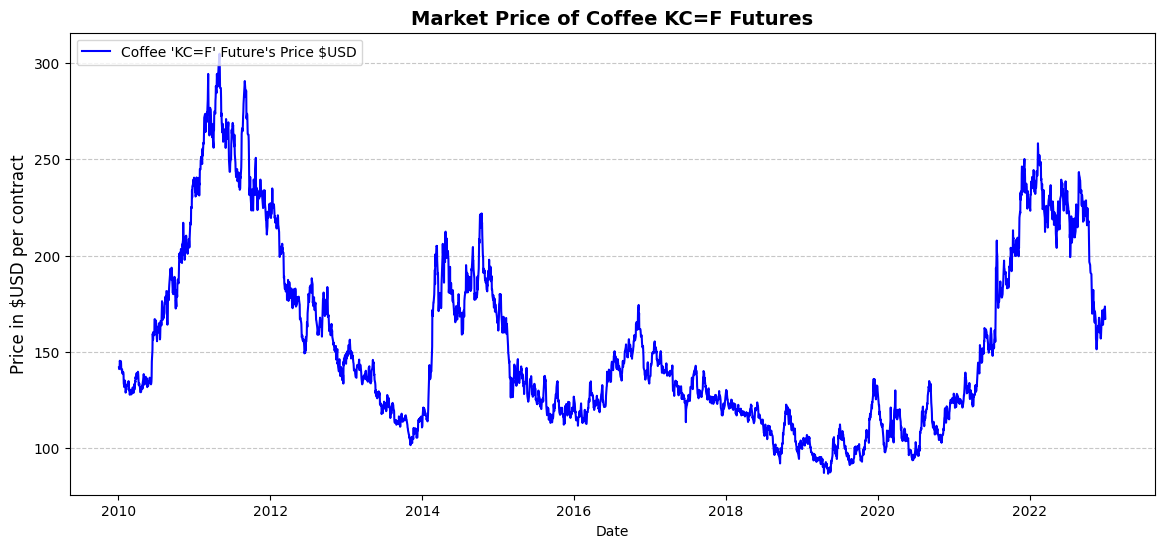

In [3]:
# Importing data
coffee = yf.Ticker('KC=F')
coffee_data = yf.download('KC=F', start='2010-01-01', end='2023-01-01')

# Visualization of the market price of gas storage contracts
plt.figure(figsize=(14, 6))
plt.plot(coffee_data['Close'], color='blue', label="Coffee 'KC=F' Future's Price $USD")
plt.xlabel('Date')
plt.ylabel('Price in $USD per contract', fontsize=12)
plt.title('Market Price of Coffee KC=F Futures', fontsize=14, weight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The fair price of the coffee futures contract is $169.828 per pound.
Parameters: 
 Spot price of coffee: $167.300 
 Risk-free rate: 2.0% 
 Storage cost: 1.0% 
 Time to maturity: 0.5 years


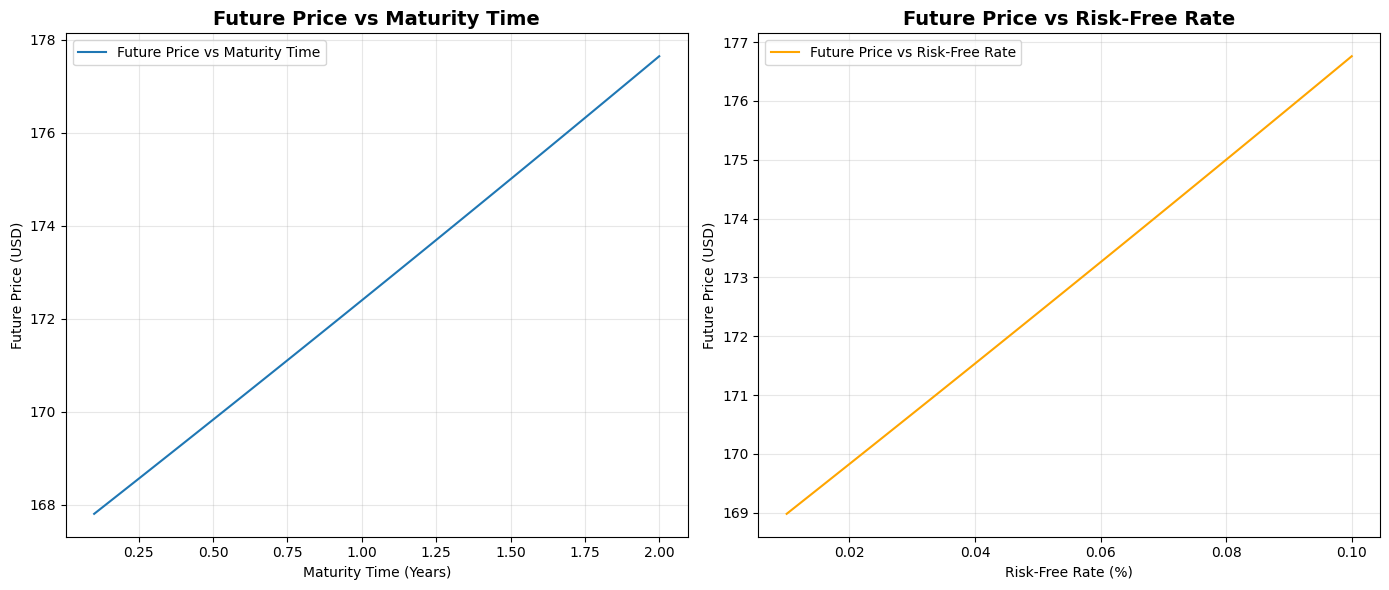

In [4]:
# Pricing a Future contract for Coffee

# Relevant parameters
S_t = (coffee_data['Close'].iloc[-1]).iloc[0] # Spot price of coffee (USD)
r = 0.02  # Risk-free rate (2%)
d = 0.01  # Storage cost (1%)
T = 0.5    # Time to maturity (in years)
T_values = np.linspace(0.1, 2, 100)  # Maturity times from 0.1 to 2 years
r_values = np.linspace(0.01, 0.1, 100)  # Risk-free rates from 1% to 10%

# Cost of Carry formula
def cost_of_carry(S_t, r, d, T):
    '''
    Return the cost of carry for a given spot price, risk-free rate, storage cost, and time to maturity.
    
    Parameters:
    S_t (float): Spot price of the underlying asset
    r (float): Risk-free rate
    d (float): Storage cost
    T (float): Time to maturity
    
    Returns:
    float: Cost of carry
    '''
    return S_t * np.exp((r + d) * T)

# Calculate the fair price of the futures contract
F_t = cost_of_carry(S_t, r, d, T)
# Calculate future prices for risk-free rates
F_t_vs_r = [cost_of_carry(S_t, r=r, d=d, T=T) for r in r_values]

# Print the result
print(f"The fair price of the coffee futures contract is ${F_t:.3f} per pound.")
print(f'Parameters: \n Spot price of coffee: ${S_t:.3f} \n Risk-free rate: {r*100}% \n Storage cost: {d*100}% \n Time to maturity: {T} years')

# Calculate future prices for each maturity time
F_t_vs_T = [cost_of_carry(S_t, r, d, T) for T in T_values]

# Plotting
plt.figure(figsize=(14, 6))

# Plot 1: Future price vs Maturity Time
plt.subplot(1, 2, 1)
plt.plot(T_values, F_t_vs_T, label='Future Price vs Maturity Time')
plt.title('Future Price vs Maturity Time', fontsize=14, fontweight='bold')
plt.xlabel('Maturity Time (Years)')
plt.ylabel('Future Price (USD)')
plt.grid(alpha=0.3)
plt.legend()

# Plot 2: Future price vs Risk-Free Rate
plt.subplot(1, 2, 2)
plt.plot(r_values, F_t_vs_r, label='Future Price vs Risk-Free Rate', color='orange')
plt.title('Future Price vs Risk-Free Rate', fontsize=14, fontweight='bold')
plt.xlabel('Risk-Free Rate (%)')
plt.ylabel('Future Price (USD)')
plt.grid(alpha=0.3)
plt.legend()

# Show both plots side by side
plt.tight_layout()
plt.show()

Call option price for a 6-month call option at $158.935 Strike price on coffee futures: $20.52
Parameters: 
 Spot price = $167.30, 
 Strike price = $158.94, 
 Risk-free rate = 2.00%, 
 Time to maturity = 6 months, 
 Volatility = 32.89%


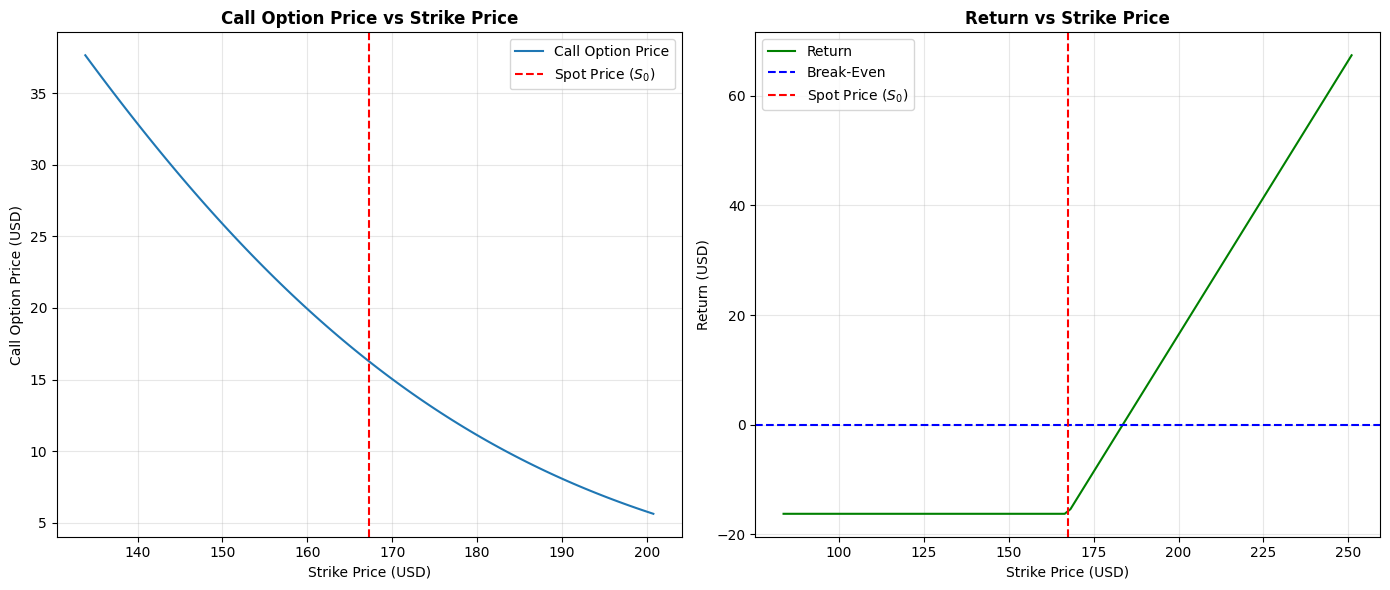

In [5]:
# Pricing a Call Option on Coffee Futures

# Relevant parameters
S_0 = (coffee_data.Close.iloc[-1]).iloc[0] # Spot price of coffee
S_x = S_0 * (1 - .05) # Strike price of coffee
r = 0.02 # Risk-free rate (2%)
T = .5 # Time to maturity (6 months)
daily_returns = coffee_data['Close'].pct_change() # Daily returns of coffee
sigma = (daily_returns.std() * np.sqrt(252)).iloc[0] # Annualized volatility of coffee

def options_parameters(S_0, S_x, r, T, sigma):
    d1 = (np.log(S_0 / S_x) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

def call_option_pricing(S_0, S_x, r, T, sigma):
    d1, d2 = options_parameters(S_0, S_x, r, T, sigma)
    call_price = S_0 * norm.cdf(d1) - S_x * np.exp(-r * T) * norm.cdf(d2)
    return call_price

call_price = call_option_pricing(S_0, S_x, r, T, sigma)
print(f'Call option price for a 6-month call option at ${S_x:.3f} Strike price on coffee futures: ${call_price:.2f}')
print(f'Parameters: \n Spot price = ${S_0:.2f}, \n Strike price = ${S_x:.2f}, \n Risk-free rate = {r*100:.2f}%, \n Time to maturity = {T*12:.0f} months, \n Volatility = {sigma*100:.2f}%')

# Range of strike prices
strike_prices = np.linspace(S_0 * 0.8, S_0 * 1.2, 100)  # Strike prices from 80% to 120% of spot price
call_prices = [call_option_pricing(S_0, S_x, r, T, sigma) for S_x in strike_prices]

# Calculate return vs asset price
asset_prices = np.linspace(S_0 * 0.5, S_0 * 1.5, 100)  # Asset prices from 50% to 150% of spot price
returns = [(price - S_0) / S_0 for price in asset_prices]

# Adjusted return calculation considering the option price
adjusted_returns = [
    max(price - S_0, 0) - call_option_pricing(S_0, S_0, r, T, sigma)  # Profit = max(asset price - spot price, 0) - call price
    for price in asset_prices
]

# Create a side-by-side plot
plt.figure(figsize=(14, 6))

# Plot 1: Call Option Price vs Strike Price
plt.subplot(1, 2, 1)
plt.plot(strike_prices, call_prices, label="Call Option Price")
plt.axvline(x=S_0, color='red', linestyle='--', label="Spot Price ($S_0$)")
plt.title("Call Option Price vs Strike Price", fontweight='bold')
plt.xlabel("Strike Price (USD)")
plt.ylabel("Call Option Price (USD)")
plt.grid(alpha=0.3)
plt.legend()

# Plot 2: Return vs Asset Price
plt.subplot(1, 2, 2)
plt.plot(asset_prices, adjusted_returns, label="Return", color='green')
plt.axhline(0, color='blue', linestyle='--', label="Break-Even")
plt.axvline(x=S_0, color='red', linestyle='--', label="Spot Price ($S_0$)")
plt.title("Return vs Strike Price", fontweight='bold')
plt.xlabel("Strike Price (USD)")
plt.ylabel("Return (USD)")
plt.grid(alpha=0.3)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


The average simulated price of the coffee futures contract at 0.5 years maturity is $168.659.


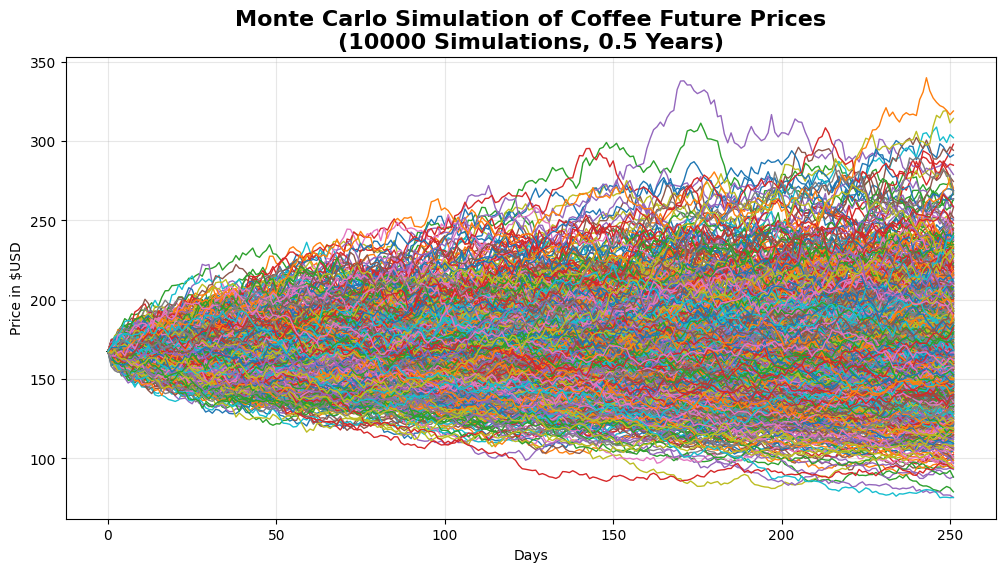

In [6]:
# Monte Carlo Simulation of Coffee Future Prices

# Relevant parameters:
S_0 = (coffee_data['Close'].iloc[-1]).iloc[0] # Initial price, here spot price
r = 0.02 # Risk-free rate (2%)
daily_returns = coffee_data['Close'].pct_change() # Daily returns of coffee
sigma = (daily_returns.std() * np.sqrt(252)).iloc[0] # Annualized volatility of coffee
T = .5 # Simulated period (in years)
num_sims = 10000 # Number of simulations
num_steps = 252 # Number of steps in each simulation (daily)

# Time incremets
dt = T / num_steps

# Simulating future prices
np.random.seed(42)
price_paths = np.zeros((num_steps, num_sims))
price_paths[0] = S_0
for t in range(1, num_steps):
    z = np.random.standard_normal(num_sims)
    price_paths[t] = price_paths[t-1] * np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)

# Calculating the average simulated price at maturity
average_simulated_price = np.mean(price_paths[-1])
print(f"The average simulated price of the coffee futures contract at {T} years maturity is ${average_simulated_price:.3f}.")


# Plotting the Monte Carlo simulation (1 every 10 simulations)
plt.figure(figsize=(12, 6))
for i in range(0, num_sims, 10):  # Plot 1 every 10 simulations
    plt.plot(price_paths[:, i], linewidth=1)
plt.title(f"Monte Carlo Simulation of Coffee Future Prices\n({num_sims} Simulations, {T} Years)", fontsize=16, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Price in $USD")
plt.grid(alpha=0.3)
plt.show()
